# Tutorial

For any issues please refer refer to the bibliography in the README or reach me out by email.

In [1]:
# full width notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib


In [3]:
# 
# Importing functions 
from import_excel import import_excel
from calc_translations import load_trans
from calc_translations import translate
from wavelet_decomposition import compute_betas
from wavelet_decomposition import stack_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct
from wavelet_decomposition import sine_function
from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft

# All control parameters goes here

In [4]:
#
# Path
path_input_data = ""
input_file = 'input_time_series.xlsx'
#
beta_path = "betas\\square_shape\\" # Results of the wavelet decomposition are saved here in .xlsx files

#
path_trans = 'translation//' # Translations are saved here


In [5]:
#
# Options of the wavelet decomposition
vy = 6  # vectors per yearsave
vw = 3  # vectors per week
vd = 6  # vectors per day
#
# Time scales of the wavelet decomposition
time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

# Importing excel time series

* Time series are imported from excel files. The should be formated like the example "input_time_series.xlsx".
     * Time Series are provided by trhe French TSO, RTE (https://www.rte-france.com/fr/eco2mix/eco2mix)
     * input_time_series.xlsx provides 7 years of French Wind power, Solar PV production and consumption
 
 <br />
 
* All years are renormalized to 1 MW so that They can be compared with one another
    * Signal is the renormalized by load_factor = 54 GW  for the French case
    
<br />

* For mathematical purposes signals need to have 64 data per day. The functioninport_excel() interpolate signals from dpd points to ndpd = 64
<br />

In [6]:
# ------- Controle parameters -------

# Wich time series do you want to import from the excel file ?
time_series = ['Consumption', 'Wind', 'PV']
# for the signal interpolation
dpd = 48 # data per year
ndpd = 64 # new data per year (for the interpolation)
dpy = 365 # data per year :  cut the leap years to 365 years (annee bissexitle)
signal_length = ndpd * dpy

#
load_factor = 54e+3 # MW
#Mean value of electricity load

There is 7 years imported
['2012', '2013', '2014', '2015', '2016', '2017', '2018']


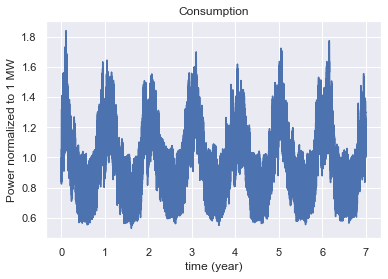

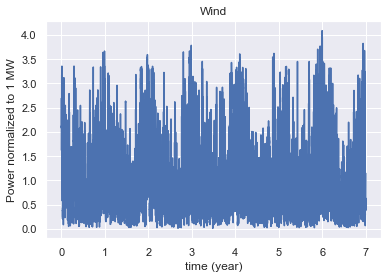

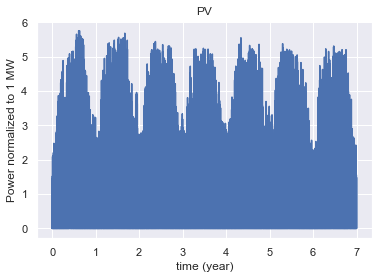

In [7]:
# ----------------------------------
# ------ Importing data ------------
# ----------------------------------

stacked_input_data, years = import_excel(path_input_data,input_file, 
                                    dpd ,ndpd, dpy, time_series, 
                                    interp=True) # interpolate data from dpd to ndpd numper of points per day

# ------ Saving data -------
# Once data are computed, comment lines bellow and uncomment the last one
pkl.dump([stacked_input_data, years], open('imported_signal' + '.p', "wb") )

# Uncomment once date are computed
# [stacked_input_data, years]= pkl.load(open('imported_signal' + '.p', "rb"))

# Starting the wavelet decomposition

<br />

Signal is decomposed over a set of wavelets of 15 time scales :  [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] hours
              
The time scale could be understood as the duration of charge-discharge of a storage device

<br />

<ins>This set of wavelets is built such that:</ins>



- There is 3 mother wavelets with different durations : _Year_ , _Week_ and _Day_
<br />

- Those 3 wavelets have a physical meaning and account for human and season cycles. Therefore, we want to make sure that the year time scale is properly center over the year (summer un summer and winter in winter), that dayly wavelets are starting from 12pm to 12 pm and not 5am to 5am,...
<br />

- For this  reason we should compute and use translations, as shown in the cell below
<br />

- The mother wavelets are then divided in daugther wavelets

<br />

_The 3 mother wavelets have to be adjusted on the signal: the _year_ should fit on the seasonal fluctuation, the _week_ on the week and weekend cycle, the _day_ on the nigh / day cycle
    * Translations are computed with the "Consumption signal" for each year
    * The same translations are reused for for the other time series

In [8]:
# ----------------------------------
# ------ Translations ------------
# ----------------------------------
'''
First, optimal translations for the year, week and day mother wavelets
- if do_calc is false, translations are imported.
'''
trans_file = 'trans_square_12_18'

trans_square = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consumption',
                   ndpd, dpy, 
                   'square', #shape of the wavelet: either 'square' or 'sine'
                    do_calc = False) # False: import translations. True: compute new translations

Importing translations


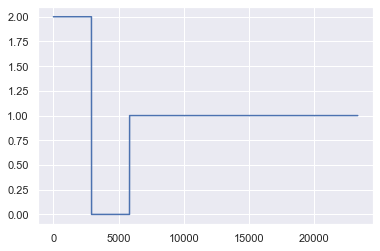

In [9]:
test_function= [2]*365*8+ [0]*365*8 + [1]*365*(64-16)
len(test_function)== 365*64
plt.plot(test_function)

In [10]:
# stacked_input_data = {'test': test_function}
# time_series = ['test']
# signal = 'test'
# years=['2012']
# year = '2012'

In [11]:
# ----------------------------------------------------
# ------ Performing wavelet decomposition ------------
# ----------------------------------------------------
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine' or 'square' shape
- To compute new matrix use imp_matrix = False. It can take quite some time !
'''
path_matrix = "saved_matrix\\square_shape\\"
stacked_betas_square, saved_sheets_square = compute_betas(time_series, stacked_input_data,
                 vy, vw, vd, dpy, ndpd, years,
                 trans_square,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True)

pkl.dump([stacked_betas_square, saved_sheets_square], open('betas_saved_square' + '.p', "wb"))

# [stacked_betas_square, saved_sheets_square] = pkl.load(open('betas_saved_square' + '.p', "rb"))

saved_matrix\square_shape\A_2012.npz
Importing matrix A square
Square sparsee matrix or year 2012 has been imported
saved_matrix\square_shape\A_2013.npz
Importing matrix A square
Square sparsee matrix or year 2013 has been imported
saved_matrix\square_shape\A_2014.npz
Importing matrix A square
Square sparsee matrix or year 2014 has been imported
saved_matrix\square_shape\A_2015.npz
Importing matrix A square
Square sparsee matrix or year 2015 has been imported
saved_matrix\square_shape\A_2016.npz
Importing matrix A square
Square sparsee matrix or year 2016 has been imported
saved_matrix\square_shape\A_2017.npz
Importing matrix A square
Square sparsee matrix or year 2017 has been imported
saved_matrix\square_shape\A_2018.npz
Importing matrix A square
Square sparsee matrix or year 2018 has been imported
saved_matrix\square_shape\A_2012.npz
Importing matrix A square
Square sparsee matrix or year 2012 has been imported
saved_matrix\square_shape\A_2013.npz
Importing matrix A square
Square sp

In [12]:
# df = preplotprocessing(vy, vw , vd, ndpd, dpy, signal, #Then the kind of signal. In this tutorial its either 'Consommation', 'Eolien' or 'Solaire
#                       year, years,
#                       saved_sheets_square, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
#                       do_trans = None) # Eventualy retranslate the decomposition to make it feet to the week, day and sesonal cycles
# plot_betas_heatmap(df, signal, year , ndpd,
#                       cmin= -0.1,
#                       cmax= 0.1,
#                     ccenter = None)

In [13]:
#
# The wavelet decomposition is saved in a disctionnary with the following sstructure:
print(saved_sheets_square.keys())
print(saved_sheets_square['Consumption'].keys())
print(saved_sheets_square['Consumption']["2012"][14]) # 14th time scale

dict_keys(['Consumption', 'Wind', 'PV'])
dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
[0.16450030884792283]


# Plots


## Heatmaps

<br />

The wavelet decomposition can be depicted with a heatmaps.

<br />

Example in the cells below

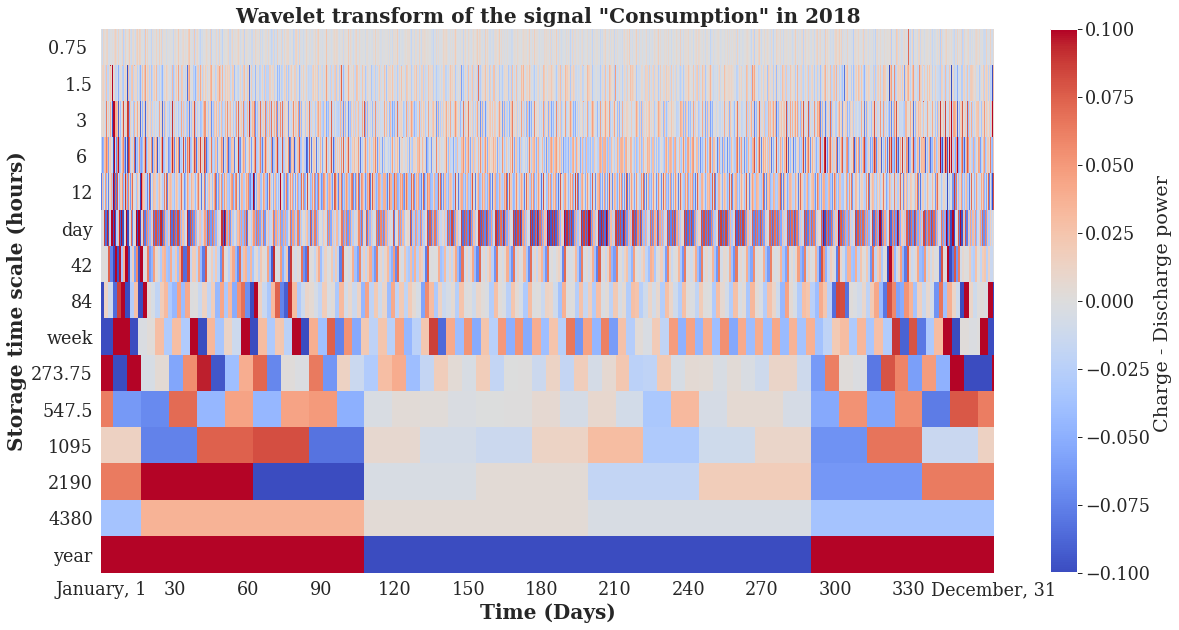

In [14]:
# First, select the year
year = '2018'
# The directory where the matrix is saved. In this case, we are using square matric
# Replace square by sine for the sine wavelet decomposition
path_matrix = "saved_matrix\\square_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# The signal on which you want to process the wavelet decomposition : 'Consumption', 'Wind' or 'PV'
signal = 'Consumption'
# 
df= preplotprocessing(vy, vw , vd, ndpd, dpy, signal, #Then the kind of signal. In this tutorial its either 'Consommation', 'Eolien' or 'Solaire
                      year, years,
                      time_scales,
                      saved_sheets_square, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      matrix)

plot_betas_heatmap(df, signal, year , ndpd,
                      cmin= -0.1,
                      cmax= 0.1,
                    ccenter = None)

# Wavelet _Versus_ Fourier transform

C:\Users\AC252489\Documents\These\wavelet_decomposition-master\plots.py:90: RuntimeWarning: divide by zero encountered in true_divide
  xf = 8760./np.linspace(0, 1.0/(2.0*T), int(N/2))


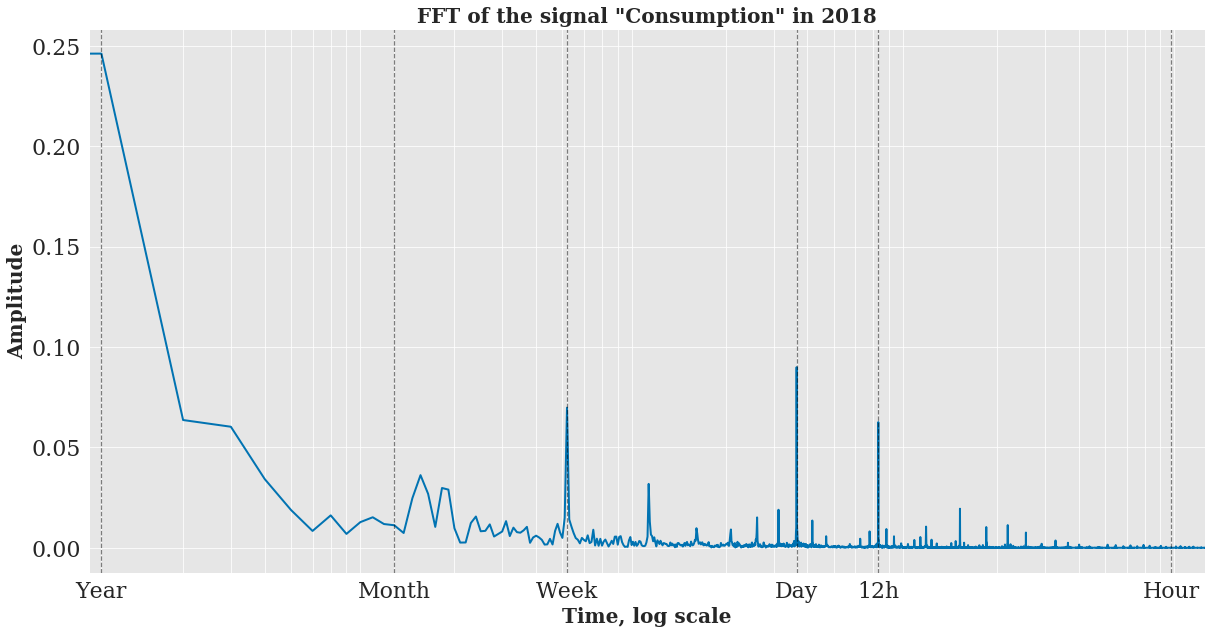

In [15]:
year='2018' # year of the decomposition
index = years.index(year)

signal = 'Consumption'

input_data = stacked_input_data[signal][signal_length*index:signal_length*(index+1)]
fft(ndpd, dpy, signal, year, input_data)

# Computing Energy, Power, and Nb of Cycles
<br/>

### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

<br/>

***Satisfaction rate:*** Percentage of the time the consumption is satisfied. Examples:
* If satisfaction rate = 90%: At the day scales 0.9*365=328 days per year, the energy demand will be satisfied. We get rid of the 365-328=37 days with the highest electricity consumption
* Here the signal last 7 years. With a 90% satisfaction rate we get rid of the 37*7 extreme days over the last 7 years

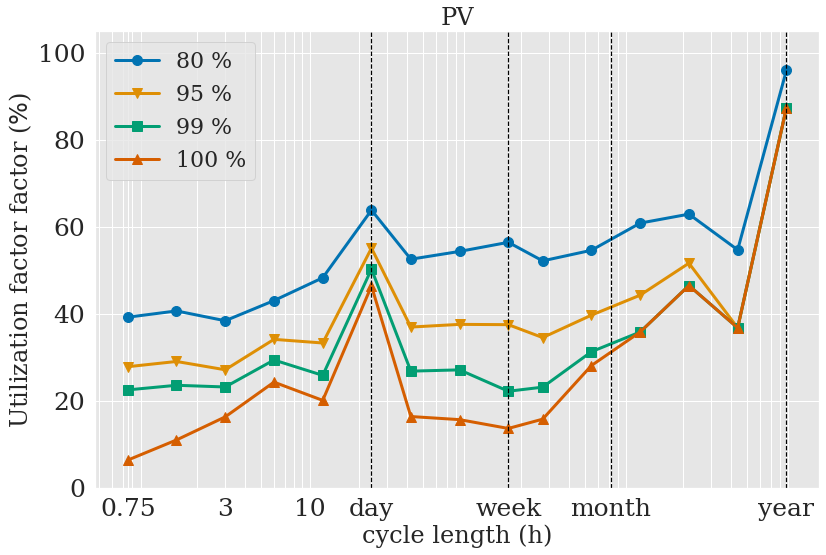

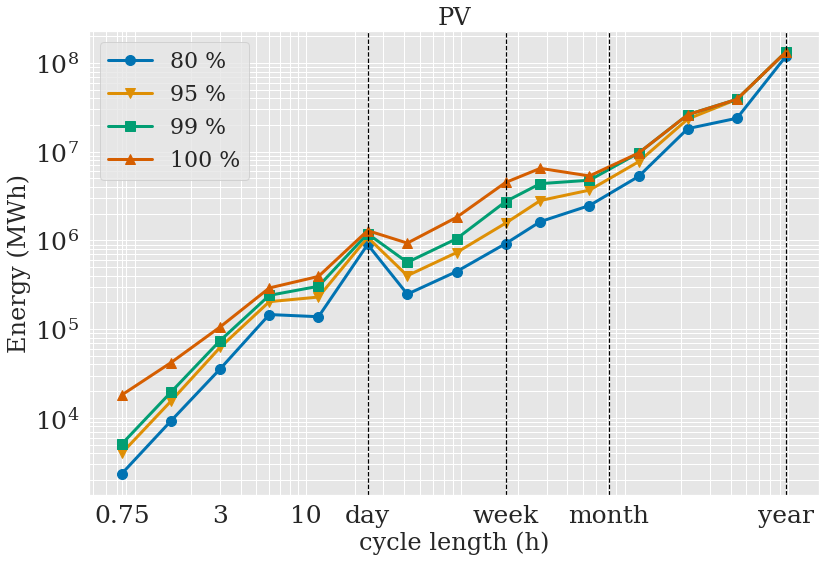

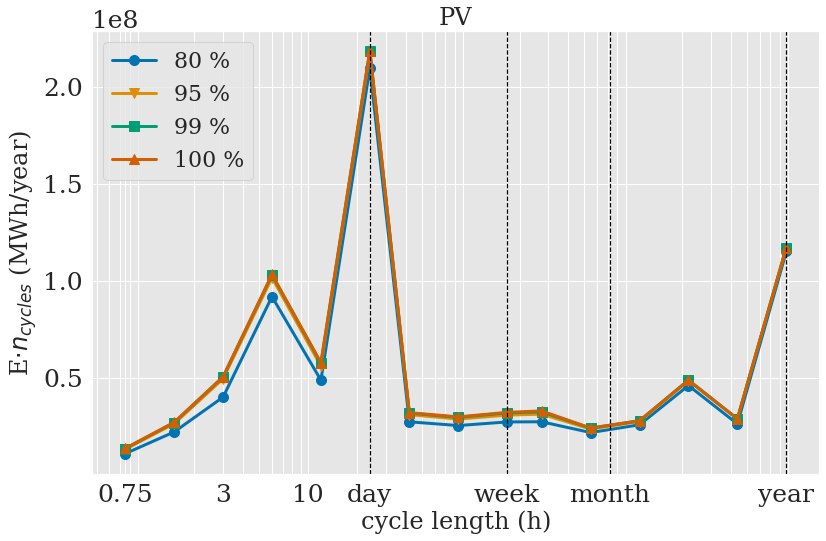

In [16]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = 'PV'
conso = stacked_betas_square['Consumption']
prod =  stacked_betas_square['PV']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the time the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

array([-9.9161108e-07, -9.9161108e-07, -9.9161108e-07, ...,
       -9.9255723e-07, -9.9255723e-07, -9.9161108e-07])

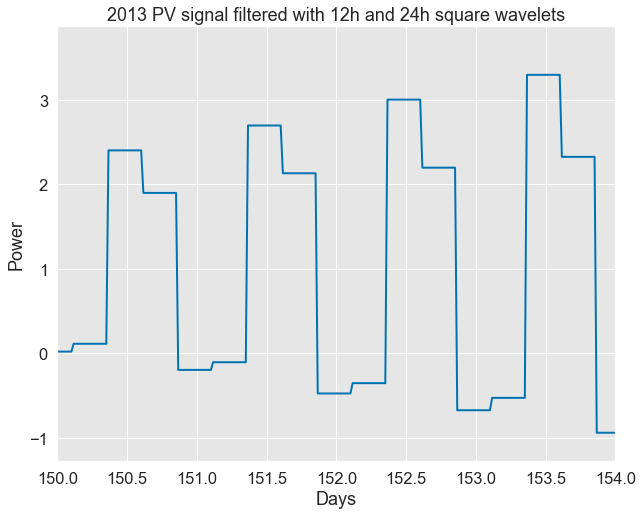

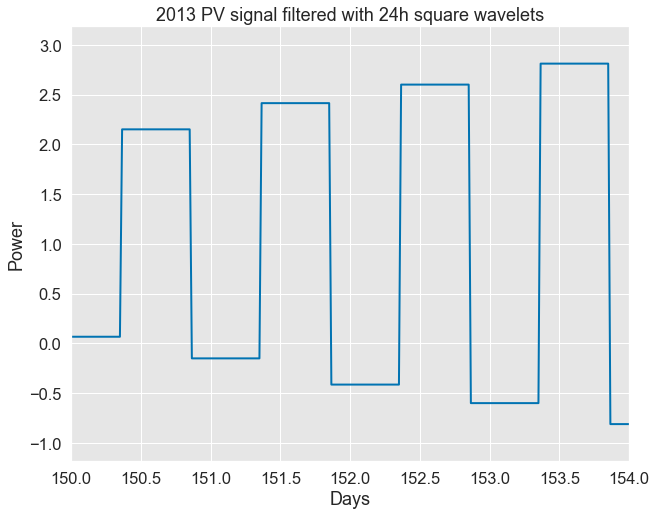

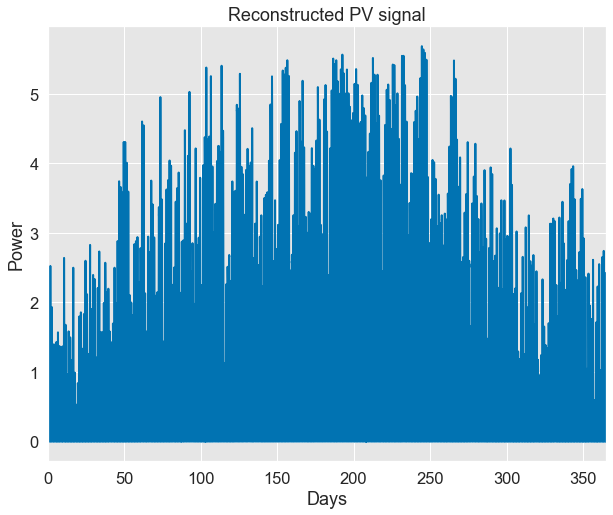

In [17]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [12, 24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 12h and 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, [24],
                matrix,saved_sheets_square['PV'][year], "2013 PV signal filtered with 24h square wavelets",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['PV'][year], "Reconstructed PV signal",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)

# To translate or not translate ?
<br/>
<center> <bold> Results comparison with translations and without translations </bold></center>

In [18]:
# -----------------------------------------------
# ------ Create translations full of zeros -----
# -----------------------------------------------
zero_trans = []
Nyears = int(len(stacked_input_data['Consumption'])/(ndpd*dpy) )
for i in range(Nyears):
    zero_trans.append([0,0,0])
    
# ----------------------------------------------------
# ------ Decomposition with without translations -----
# ----------------------------------------------------

path_matrix = "saved_matrix\\square_shape\\no_trans\\"
beta_path = "betas\\square_shape_no_trans\\"

# stacked_betas_square_no_trans, saved_sheets_square_no_trans = compute_betas(time_series, stacked_input_data,
#                  vy, vw, vd, dpy, ndpd, years,
#                  zero_trans,
#                  path_matrix,
#                  beta_path, wl_shape ='square', imp_matrix = True)

# pkl.dump([stacked_betas_square_no_trans, saved_sheets_square_no_trans], open('betas_saved_square_no_trans' + '.p', "wb"))

[stacked_betas_square_no_trans, saved_sheets_square_no_trans] = pkl.load(open('betas_saved_square_no_trans' + '.p', "rb"))

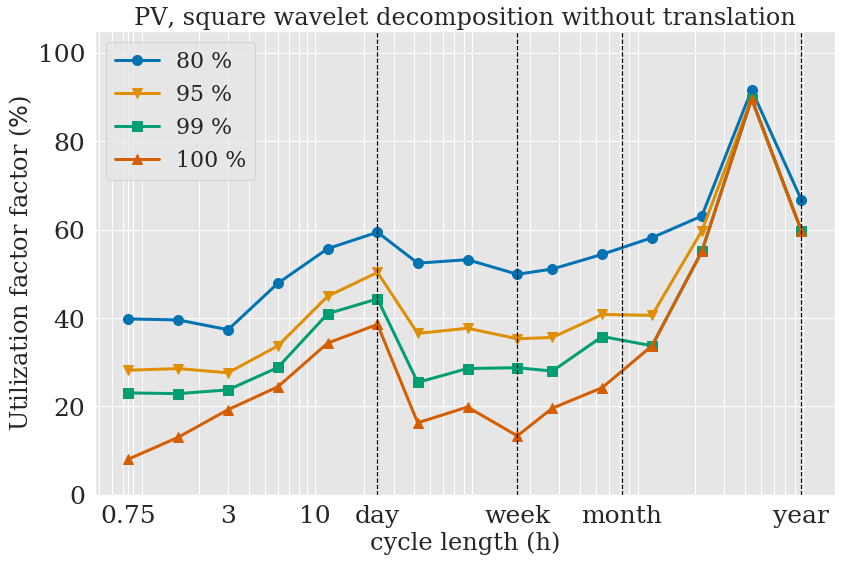

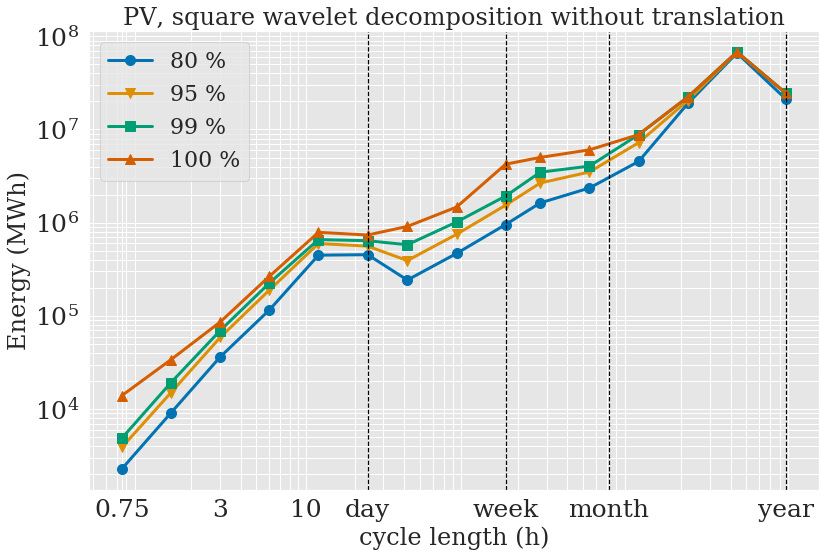

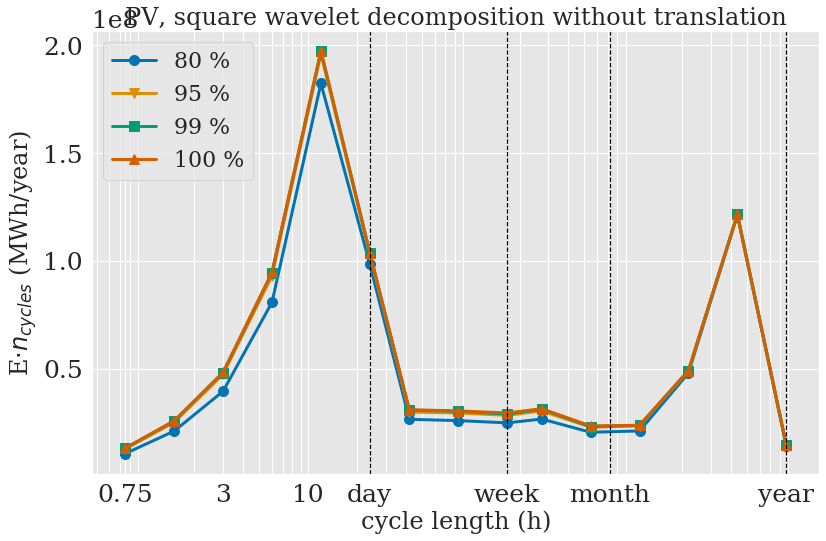

In [19]:
# --------------------------------------
# -- Same plots without translations ---
# --------------------------------------
scenario_name = 'PV, square wavelet decomposition without translation'
conso = stacked_betas_square_no_trans['Consumption']
prod =  stacked_betas_square_no_trans['PV']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_square_PV_no_trans = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor, shape = 'square')
plot_EPN(results_square_PV_no_trans['emax'], results_square_PV_no_trans['pmax'], results_square_PV_no_trans['n'], results_square_PV_no_trans['uf'], results_square_PV_no_trans['serv'],
         time_scales, satisfactions, scenario_name )

# Sine and square shape wavelets
<br/>
Wavelets can take various shapes. We used here both sine and square shape. Here is and example of a sine shape decomposition

In [20]:
# -------- Import translations -----
trans_file = 'trans_sine_12_18'

trans_sine = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'sine', do_calc=False)
# ------Perform wavelet decomposition ----

beta_path = "betas\\sine_shape\\"

path_matrix = "saved_matrix\\sine_shape\\"

stacked_betas_sine, saved_sheets_sine = compute_betas(time_series, stacked_input_data,
                 vy,vw,vd,dpy, ndpd, years,
                 trans_sine,
                 path_matrix,
                 beta_path, wl_shape ='sine', imp_matrix = True)

# ----- Plot 100% PV scenario ---

scenario_name = 'PV, sine wavelet decomposition'
sine_conso = stacked_betas_sine['Consumption']
sine_prod =  stacked_betas_sine['PV']

sine_pmc = [np.array(sine_prod[i]) - np.array(sine_conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100]
satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results_sine = calc_epn(sine_pmc, satisfactions, time_scales, dpy, load_factor, shape = 'sine')

Importing translations
saved_matrix\sine_shape\A_2012.npz
Importing matrix A sine
Sine sparse matrix or year 2012 has been imported
saved_matrix\sine_shape\A_2013.npz
Importing matrix A sine
Sine sparse matrix or year 2013 has been imported
saved_matrix\sine_shape\A_2014.npz
Importing matrix A sine
Sine sparse matrix or year 2014 has been imported
saved_matrix\sine_shape\A_2015.npz
Importing matrix A sine
Sine sparse matrix or year 2015 has been imported
saved_matrix\sine_shape\A_2016.npz
Importing matrix A sine
Sine sparse matrix or year 2016 has been imported
saved_matrix\sine_shape\A_2017.npz
Importing matrix A sine
Sine sparse matrix or year 2017 has been imported
saved_matrix\sine_shape\A_2018.npz
Importing matrix A sine
Sine sparse matrix or year 2018 has been imported
saved_matrix\sine_shape\A_2012.npz
Importing matrix A sine
Sine sparse matrix or year 2012 has been imported
saved_matrix\sine_shape\A_2013.npz
Importing matrix A sine
Sine sparse matrix or year 2013 has been impor

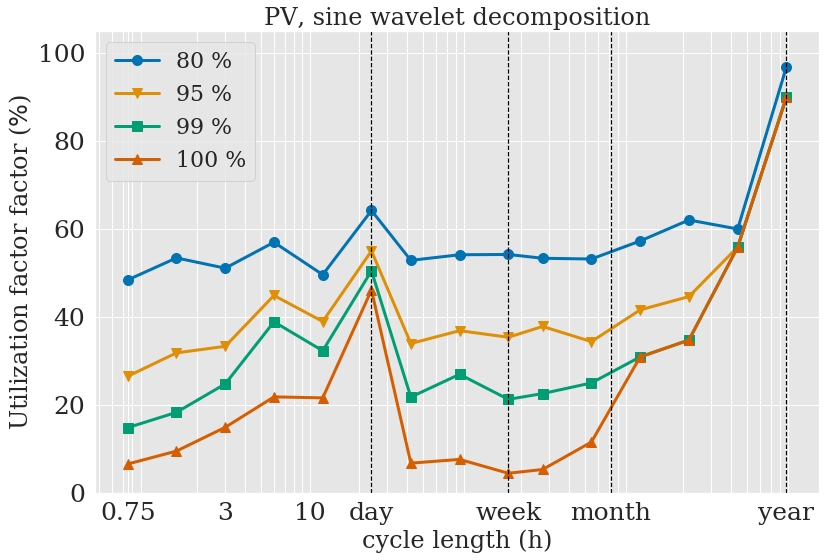

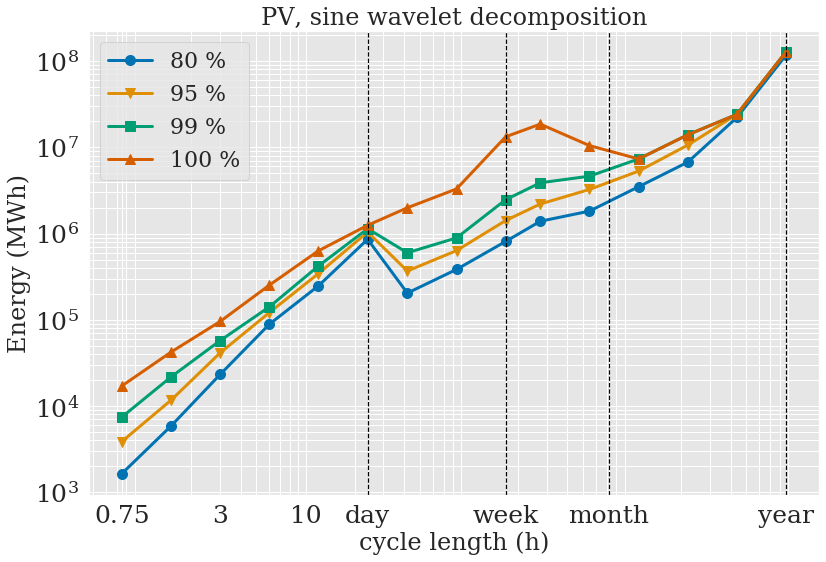

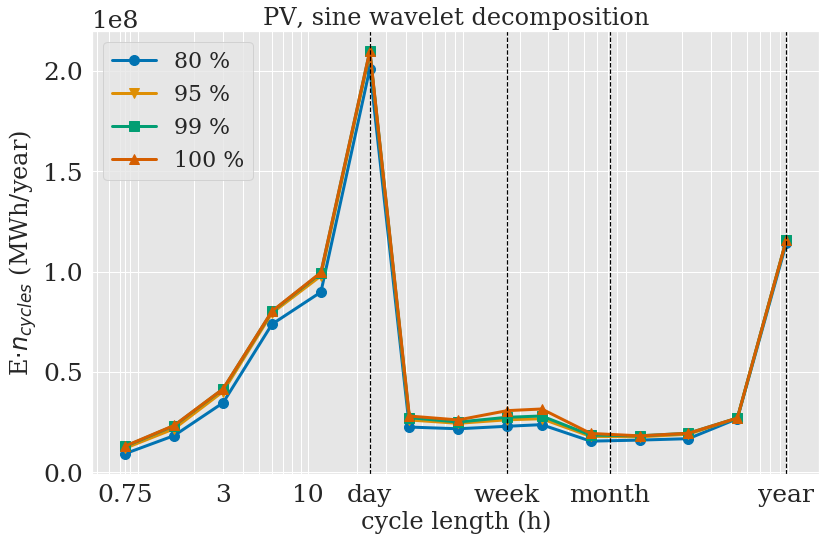

In [21]:
plot_EPN(results_sine['emax'], results_sine['pmax'], results_sine['n'], results_sine['uf'], results_sine['serv'],
         time_scales, satisfactions, scenario_name )

array([-2.36113695e-09, -7.93537047e-08, -3.28472518e-08, ...,
       -7.52335356e-08,  1.68324709e-08,  2.61788036e-08])

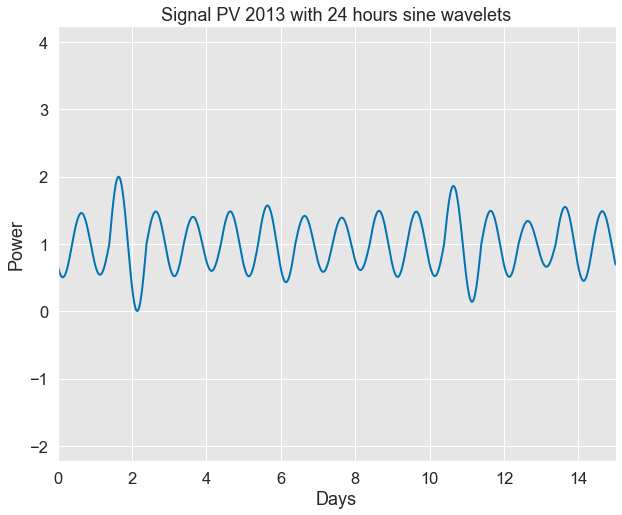

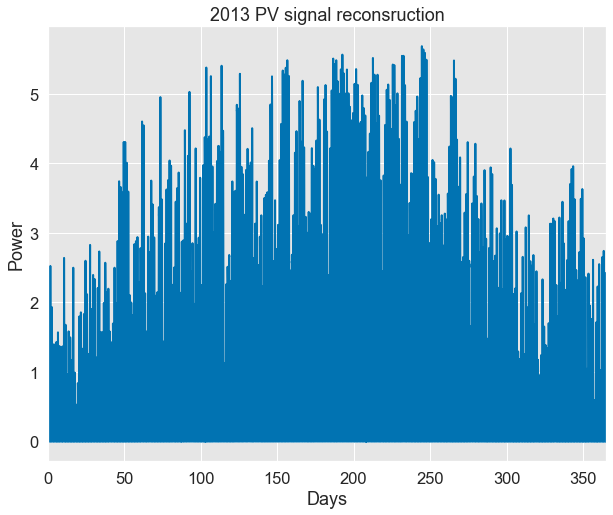

In [22]:
# -------- Reconstruct signal -----

year = '2013'
path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [24],
                matrix,saved_sheets_sine['PV'][year], "Signal PV 2013 with 24 hours sine wavelets",
                xmin=0, xmax=15,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_sine['PV'][year], "2013 PV signal reconsruction",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)